# Figure 7 and S7

This notebook contains code for reproducing results from Figure 7 and S7 in Yang\*, Jones\*, et al _bioRxiv_ 2021.

In [45]:
import os

import ete3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.auto import tqdm

import utilities

In [2]:
data_directory = "/path/to/KPTracer-Data"

adata = sc.read_h5ad(f"{data_directory}/expression/adata_processed.combined.h5ad")
allele_table = pd.read_csv(f"{data_directory}/KPTracer.alleleTable.FINAL.txt", sep='\t', index_col = 0)

/home/eecs/mattjones/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Evolutionary Coupling for 3724 Tumor Regions & Mets - Figure 7B

Phylogenetic distances were computed using the script in `reproducibility/Figure5_S5/scripts/compute_dissimilarity_matrices.py`

In [3]:
# read in primary tumor tree and allele Table
tumor = '3724_NT_All'
graph = utilities.prepare_tumor_tree(tumor, adata, f"{data_directory}/trees')

In [4]:
phylogenetic_distance_matrix = pd.read_csv(f"../Figure5_S5/data/{tumor}_phylogenetic_distance_matrix.tsv", sep='\t', index_col = 0)

In [11]:
s1_cells = adata[adata.obs['Tumor'] == '3724_NT_S1'].obs_names
l1_cells = adata[adata.obs['Tumor'] == '3724_NT_L1'].obs_names
l2_cells = adata[adata.obs['Tumor'] == '3724_NT_L2'].obs_names
l3_cells = adata[adata.obs['Tumor'] == '3724_NT_L3'].obs_names

leaves = phylogenetic_distance_matrix.index.values
s1_cells = np.intersect1d(leaves, s1_cells)
l1_cells = np.intersect1d(leaves, l1_cells)
l2_cells = np.intersect1d(leaves, l2_cells)
l3_cells = np.intersect1d(leaves, l3_cells)

In [14]:
tumor_parts = adata.obs.loc[adata.obs['Tumor'] == '3724_NT_T1', 'SubTumor'].unique()


In [18]:
tumor_parts = adata.obs.loc[adata.obs['Tumor'] == '3724_NT_T1', 'SubTumor'].unique()
leaves = phylogenetic_distance_matrix.index.values

part2cells = {'S': s1_cells, 'L1': l1_cells, 'L2': l2_cells, 'L3': l3_cells}
for part in tumor_parts:
    part2cells[part] = np.intersect1d(adata.obs.loc[adata.obs['SubTumor'] == part].index.values, leaves)
    
average_distances = {}
for part in tqdm(part2cells):
    average_distances[part] = {}
    
    cells1 = part2cells[part]
    for part2 in tqdm(part2cells):
        
        cells2 = part2cells[part2]
        avg_distance = np.mean(phylogenetic_distance_matrix.loc[cells1, cells2].mean(axis=1))
        
        average_distances[part][part2] = avg_distance
        
average_distances_df = pd.DataFrame.from_dict(average_distances)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [20]:
part_meta = pd.DataFrame(columns = ['part'])
for part in part2cells:
    cells = part2cells[part]
    df = pd.DataFrame([part]*len(cells), index = cells, columns = ['part'])
    part_meta = pd.concat([part_meta, df])
    
evo_coupling = utilities.compute_evolutionary_coupling(phylogenetic_distance_matrix, part_meta['part'], B=100)

  0%|          | 0/100 [00:00<?, ?it/s]

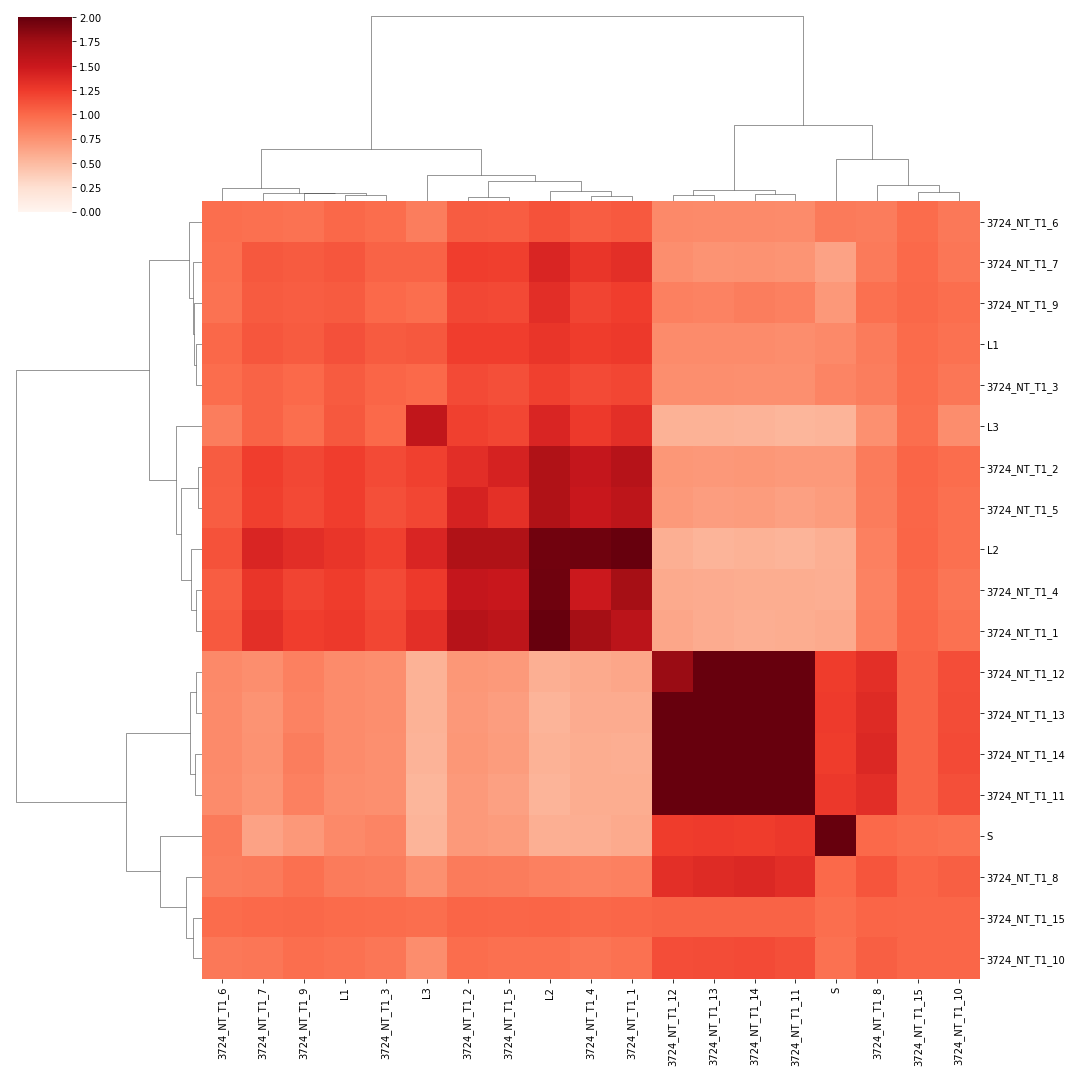

In [21]:
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
Z = np.max(evo_coupling.abs().values.ravel().ravel())
evo_coupling_sim = np.exp(-1 * (evo_coupling / Z))

linkage = hc.linkage(evo_coupling, method='ward')

sns.clustermap(evo_coupling_sim, cmap='Reds', row_linkage=linkage, col_linkage=linkage, vmin = 0, vmax=2, figsize=(15,15))

## Comparison of expansion similarity to metastases

### Plot results for one tumor - Figure 7D-F, S7D

Expansions were inferred using the code described in `KPTracer-release/reproducibility/Figure2_S2/`

In [62]:
parental_tumor = '3515_Lkb1_T1'
met_family = '3515_Lkb1_T1_Fam'

parental_tree = ete3.Tree(f"{data_directory}/trees/{parental_tumor}_tree.nwk", format=1)

phylogenetic_distance_matrix = pd.read_csv(f"./data/{met_family}/phylogenetic_distance_matrix.tsv", sep='\t', index_col = 0)

expanding_cells = []
expansion_to_cells = {}
leaves = phylogenetic_distance_matrix.index.values

for i in range(1, 4):
    
    expansion_fp = f"{data_directory}/expansions/clonal_expansions.{parental_tumor}.expansion{i}.txt"
    if os.path.isfile(expansion_fp):

        # stores a list of leaves in each expansion
        expansion = pd.read_csv(expansion_fp, sep='\t', index_col = 0).iloc[:,0]
        expansion = np.intersect1d(expansion, leaves)
        expansion_to_cells[f'expansion-{i}'] = expansion
        expanding_cells += list(expansion)
            
non_expanding = np.setdiff1d(allele_table.loc[allele_table['Tumor'] == parental_tumor, 'cellBC'].unique(), expanding_cells)
non_expanding = np.intersect1d(non_expanding, leaves)

expansion_to_cells['non-expanding'] = non_expanding

for expansion in expansion_to_cells:
    print(f'{len(expansion_to_cells[expansion])} detected in {expansion}')

433 detected in expansion-1
149 detected in expansion-2
128 detected in non-expanding


In [65]:
mets = adata.obs.loc[adata.obs['MetFamily'] == parental_tumor, 'Tumor'].unique()
mets = [m for m in mets if m != parental_tumor]

met_to_cells = {}
for met in mets:
    met_cells = adata.obs[adata.obs['Tumor'] == met].index.values
    met_cells = np.intersect1d(met_cells, phylogenetic_distance_matrix.index.values)
    met_to_cells[met] = met_cells
    print(f'Found {len(met_cells)} cells in {met}')

Found 60 cells in 3515_Lkb1_L1
Found 362 cells in 3515_Lkb1_K2
Found 361 cells in 3515_Lkb1_K3
Found 241 cells in 3515_Lkb1_L2
Found 78 cells in 3515_Lkb1_N1
Found 66 cells in 3515_Lkb1_K1


In [66]:
met_to_expansions = {}

for met in met_to_cells.keys():
    met_to_expansions[met] = {}
    
    for expansion_name in expansion_to_cells.keys():
        met_to_expansions[met][expansion_name] = []
        expanding_cells = expansion_to_cells[expansion_name]
        for cell in tqdm(met_to_cells[met]):
            met_to_expansions[met][expansion_name] += phylogenetic_distance_matrix.loc[cell, list(expanding_cells)].tolist()

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [67]:
met_to_expansion_df = pd.DataFrame(columns=['Sample', 'Expansion', 'Dissimilarity'])

for sample in met_to_expansions:
    
    for expansion_name in met_to_expansions[sample]:
        
        entries = met_to_expansions[sample][expansion_name]

        new_df = pd.DataFrame([sample]*len(entries), columns = ['Sample'])
        new_df['Expansion'] = [expansion_name]*len(entries)
        new_df['Dissimilarity'] = entries
        met_to_expansion_df = pd.concat([met_to_expansion_df, new_df])

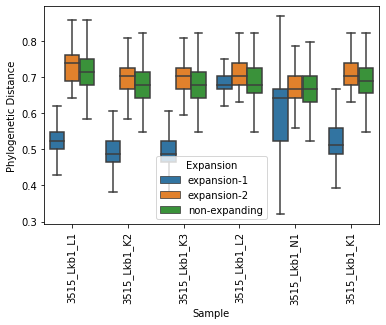

In [68]:
sns.boxplot(data=met_to_expansion_df, x='Sample', y='Dissimilarity', hue='Expansion', showfliers=False)
plt.ylabel("Phylogenetic Distance")
plt.xticks(rotation=90)
plt.show()

## Assess transcriptional similarity between expansions and metastases


### Evaluate similarity - Figure 7G, S7E

In [101]:
parental_tumor = '3724_NT_T1'
met_family = '3724_NT_All'

parental_tree = ete3.Tree(f'{data_directory}/trees/{parental_tumor}_tree.nwk', format=1)
family_tree = ete3.Tree(f'{data_directory}/trees/{met_family}_tree.nwk', format=1)

expanding_cells = []
expansion_to_cells = {}
leaves = family_tree.get_leaf_names()

for i in range(1, 4):
    
    expansion_fp = f"{data_directory}/expansions/clonal_expansions.{parental_tumor}.expansion{i}.txt"
    if os.path.isfile(expansion_fp):

        # stores a list of leaves in each expansion
        expansion = pd.read_csv(expansion_fp, sep='\t', index_col = 0).iloc[:,0]
        expansion = np.intersect1d(expansion, leaves)
        expansion = np.intersect1d(expansion, adata.obs_names)
        expansion_to_cells[f'expansion-{i}'] = expansion
        expanding_cells += list(expansion)
            
non_expanding = np.setdiff1d(allele_table.loc[allele_table['Tumor'] == parental_tumor, 'cellBC'].unique(), expanding_cells)
non_expanding = np.intersect1d(non_expanding, leaves)

expansion_to_cells['non-expanding'] = np.intersect1d(adata.obs_names, non_expanding)

for expansion in expansion_to_cells:
    print(f'{len(expansion_to_cells[expansion])} detected in {expansion}')

9943 detected in expansion-1
4633 detected in expansion-2
199 detected in non-expanding


In [102]:
mets = adata.obs.loc[adata.obs['MetFamily'] == parental_tumor, 'Tumor'].unique()
mets = [m for m in mets if m != parental_tumor]

met_to_cells = {}
for met in mets:
    met_cells = adata.obs[adata.obs['Tumor'] == met].index.values
    met_cells = np.intersect1d(met_cells, family_tree.get_leaf_names())
    met_to_cells[met] = met_cells
    print(f'Found {len(met_cells)} cells in {met}')

Found 3782 cells in 3724_NT_S1
Found 1509 cells in 3724_NT_L2
Found 90 cells in 3724_NT_L1
Found 836 cells in 3724_NT_L3


In [103]:
met_to_expansions_txn = {}

latent = pd.DataFrame(adata.obsm['X_scVI'], index = adata.obs_names)

for met in met_to_cells.keys():
    met_to_expansions_txn[met] = {}
    
    for expansion_name in expansion_to_cells.keys():
        met_to_expansions_txn[met][expansion_name] = []
        expanding_cells = expansion_to_cells[expansion_name]
                
        for cell in tqdm(met_to_cells[met]):
            met_to_expansions_txn[met][expansion_name].append(np.sqrt( np.sum(np.mean( (latent.loc[cell] - latent.loc[expanding_cells])**2 ) ) ) )

  0%|          | 0/3782 [00:00<?, ?it/s]

  0%|          | 0/3782 [00:00<?, ?it/s]

  0%|          | 0/3782 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/1509 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

In [104]:
met_to_expansion_txn_df = pd.DataFrame(columns=['Sample', 'Expansion', 'Dissimilarity'])

for sample in met_to_expansions_txn:
    
    for expansion_name in met_to_expansions_txn[sample]:
        
        entries = met_to_expansions_txn[sample][expansion_name]
        
        new_df = pd.DataFrame([sample]*len(entries), columns = ['Sample'])
        new_df['Expansion'] = [expansion_name]*len(entries)
        new_df['Dissimilarity'] = entries                    
        met_to_expansion_txn_df = pd.concat([met_to_expansion_txn_df, new_df])

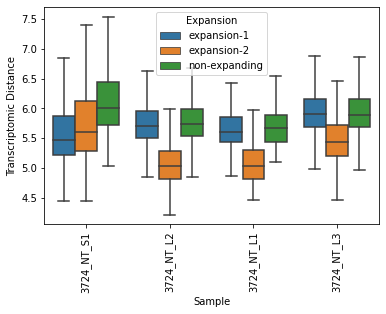

In [105]:
sns.boxplot(data=met_to_expansion_txn_df, x='Sample', y='Dissimilarity', hue='Expansion', showfliers=False)
plt.ylabel("Transcriptomic Distance")
plt.xticks(rotation=90)
plt.show()

### Plot mets with expansions on transcriptional UMAP - Figure 7E,F

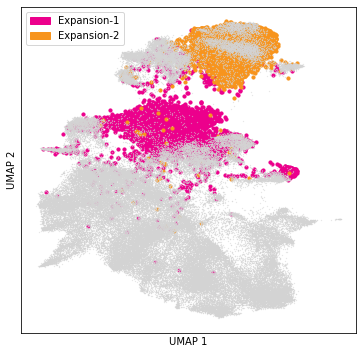

In [108]:
import matplotlib.patches as mpatches

umap = pd.DataFrame(adata.obsm['X_umap'], columns = ['D1', 'D2'], index=adata.obs_names)

patches = [mpatches.Patch(color='#EC008C', label='Expansion-1'),
          mpatches.Patch(color='#F7941D', label='Expansion-2')
          ]

expansion_to_color = {'expansion-1': '#EC008C',
                     'expansion-2': '#F7941D'}

colored_cells = []
fig, ax = plt.subplots(figsize = (6,6))
for expansion_name in expansion_to_cells.keys():
    
    if expansion_name != 'non-expanding':
    
        expansion_cells = expansion_to_cells[expansion_name]
        colored_cells += list(expansion_cells)
        plt.scatter(umap.loc[expansion_cells, 'D1'], umap.loc[expansion_cells, 'D2'], c=expansion_to_color[expansion_name], s=10)
        
bg = np.setdiff1d(umap.index.values, colored_cells)
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], c='lightgray', s=0.05)
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
ax.set_yticks([])
ax.set_xticks([])
plt.legend(handles=patches)
plt.show()

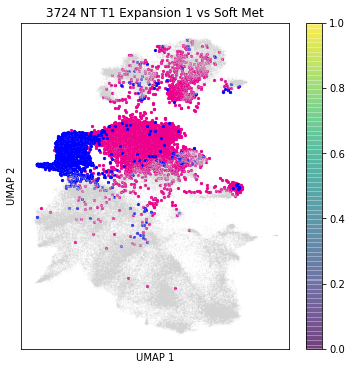

In [111]:
expansion_cells = expansion_to_cells['expansion-1']
met_cells = met_to_cells['3724_NT_S1']

bg = np.setdiff1d(umap.index.values, np.union1d(expansion_cells, met_cells))

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(umap.loc[expansion_cells, 'D1'], umap.loc[expansion_cells, 'D2'], c=expansion_to_color['expansion-1'], s=5)
plt.scatter(umap.loc[met_cells, 'D1'], umap.loc[met_cells, 'D2'], c="blue", s=5)
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], c='lightgray', s=0.01, alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
plt.colorbar()
ax.set_yticks([])
ax.set_xticks([])
plt.title(f'3724 NT T1 Expansion 1 vs Soft Met')
plt.show()

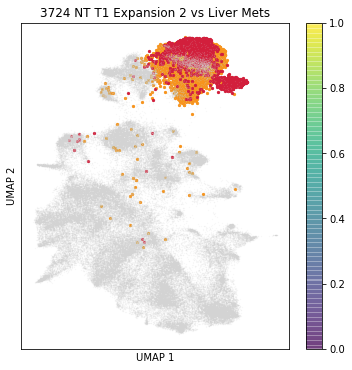

In [112]:
expansion_cells = expansion_to_cells['expansion-2']
met_cells = np.union1d(met_to_cells['3724_NT_L1'], np.union1d(met_to_cells['3724_NT_L2'], met_to_cells['3724_NT_L3']))

bg = np.setdiff1d(umap.index.values, np.union1d(expansion_cells, met_cells))

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(umap.loc[expansion_cells, 'D1'], umap.loc[expansion_cells, 'D2'], c=expansion_to_color['expansion-2'], s=5)
plt.scatter(umap.loc[met_cells, 'D1'], umap.loc[met_cells, 'D2'], c="#D21F3C", s=5)
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], c='lightgray', s=0.01, alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
plt.colorbar()
ax.set_yticks([])
ax.set_xticks([])
plt.title(f'3724 NT T1 Expansion 2 vs Liver Mets')
plt.show()